In [123]:
#Package Installations
!pip install easyfsl

In [124]:
#Importing Libraries
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-pikx79dt
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-pikx79dt
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done


In [125]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

In [126]:
#Loading YOLOv5 Model
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 16003, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 16003 (delta 21), reused 20 (delta 13), pack-reused 15967
Receiving objects: 100% (16003/16003), 14.66 MiB | 22.17 MiB/s, done.
Resolving deltas: 100% (10983/10983), done.
/content/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5


In [127]:
#Camera Capture and Image Processing
import torch
from yolov5.models.yolo import Model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True).to(device)
model.eval()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2.0.1+cu118 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 120MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [128]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
  ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [129]:
#Real-time Object Detection
image_path = take_photo()

<IPython.core.display.Javascript object>

In [130]:
#Function Duplication
def preprocess_image(image_path):
    image = Image.open(image_path)
    image_tensor = F.to_tensor(image)
    return image_tensor.unsqueeze(0).to(device)

In [131]:
image_tensor = preprocess_image(image_path)
outputs = model(image_tensor)[0]

In [132]:
def draw_boxes(image_path, outputs, threshold=0.3):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    for box in outputs:
        score, label, x1, y1, x2, y2 = box[4].item(), int(box[5].item()), box[0].item(), box[1].item(), box[2].item(), box[3].item()
        if score > threshold:
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
            text = f"{model.names[label]:s}: {score:.2f}"
            cv2.putText(image, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return image

In [133]:
from yolov5.utils.general import non_max_suppression
image_tensor = preprocess_image(image_path)
outputs = model(image_tensor)
outputs = non_max_suppression(outputs)[0]

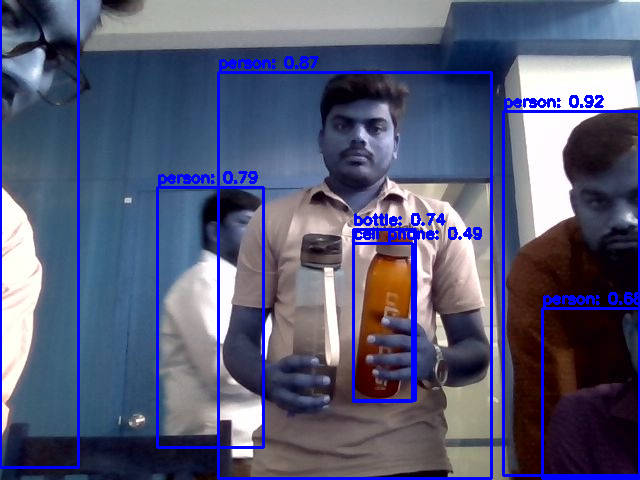

In [134]:
result_image = draw_boxes(image_path, outputs)
cv2_imshow(result_image)
